### Imports

In [1]:
import os
import pickle
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import LlamaForCausalLM, AutoTokenizer
import gymnasium as gym

from dicl import dicl

/home/abenechehab/miniconda3/envs/DICL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/abenechehab/miniconda3/envs/DICL/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


## state names

In [2]:
state_names = {
    "HalfCheetah": [
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
    ],
    "Hopper": [
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
    ],
    "Ant": [
        "rootz",
        "root_quat_x",
        "root_quat_y",
        "root_quat_z",
        "root_quat_w",
        "hip_1_angle",
        "ankle_1_angle",
        "hip_2_angle",
        "ankle_2_angle",
        "hip_3_angle",
        "ankle_3_angle",
        "hip_4_angle",
        "ankle_4_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "root_quat_x_dot",
        "root_quat_y_dot",
        "root_quat_z_dot",
        "hip_1_angle_dot",
        "ankle_1_angle_dot",
        "hip_2_angle_dot",
        "ankle_2_angle_dot",
        "hip_3_angle_dot",
        "ankle_3_angle_dot",
        "hip_4_angle_dot",
        "ankle_4_angle_dot",
    ],
    "Walker2d": [
        "rootz",
        "rooty",
        "thigh_right_angle",
        "leg_right_angle",
        "foot_right_angle",
        "thigh_left_angle",
        "leg_left_angle",
        "foot_left_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_right_angle_dot",
        "leg_right_angle_dot",
        "foot_right_angle_dot",
        "thigh_left_angle_dot",
        "leg_left_angle_dot",
        "foot_left_angle_dot",
    ],
    "Swimmer": [
        "rootx",
        "rootz",
        "rooty",
        "joint_1_angle",
        "joint_2_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "joint_1_angle_dot",
        "joint_2_angle_dot",
    ],
}

action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ],
    "Ant": [
        "hip_4_joint",
        "ankle_4_joint",
        "hip_1_joint",
        "ankle_1_joint",
        "hip_2_joint",
        "ankle_2_joint",
        "hip_3_joint",
        "ankle_3_joint",
    ],
    "Walker2d": [
        "thigh_left_joint",
        "leg_left_joint",
        "foot_left_joint",
        "thigh_right_joint",
        "leg_right_joint",
        "foot_right_joint",
    ],
    "Swimmer": [
        "joint_1",
        "joint_2",
    ],
}

## Load data

* We will be using expert trajectories from the HalfCheetah Mujoco environment for our demo. The dataset is provided in `src/dicl/data/`.

In [24]:
env_name = "Walker2d"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
data_label = "medium"

# data_path = Path("../src") / "dicl" / "data" / f"D4RL_{env_name}_{data_label}.csv"
data_path = Path(os.environ["HOME"]) / "datasets" / env_name / data_label / "X_test.csv"

# ICL parameters
context_length = 300
rescale_factor = 7.0
up_shift = 1.5

/home/abenechehab/miniconda3/envs/DICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:531: UserWarning: WARN: Using the latest versioned environment `Walker2d-v4` instead of the unversioned environment `Walker2d`.
  logger.warn(


* Pick DICL(s) or DICL(s,a) method through the number of features (choose `n_observations` for vICL).

In [25]:
# to use DICL-(s) or vICL, set include_actions to False.
# to use DICL-(s,a), set include_actions to True
include_actions = True
if include_actions:
    n_features = n_observations + n_actions
else:
    n_features = n_observations

# to use vICL, set vanilla_icl to True.
# to use DICL-(s,a) or DICL-(s), set vanilla_icl to False
vanilla_icl = False

if (n_features == n_observations) and vanilla_icl:
    method = "vicl"
elif (n_features == n_observations) and (not vanilla_icl):
    method = "dicl-s-pca"
elif n_features == n_observations + n_actions:
    method = "dicl-sa-pca"

* filter episodes that have enough context

In [26]:
# load data to get a sample episode
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype("float")
# find episodes beginnings. the restart column is equal to 1 at the start of
# an episode, 0 otherwise.
restart_index = n_observations + n_actions + 1
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

episode_endings = np.concatenate(
    [episode_starts[1:], np.array([len(restarts)])], axis=0
)
episode_lengths = episode_endings - episode_starts
possible_episodes = episode_starts[
    np.argwhere(episode_lengths > context_length + 1)
].flatten()

print(f"episode_starts: {episode_starts}")
print(f"possible episodes: {possible_episodes}")

episode_starts: [    0   673  1224  1928  2928  3928  4928  5928  6546  7123  8123  9123
  9959 10740 11460 12460 13460 14193 15193 16193 16791 17791 18317 19317]
possible episodes: [    0   673  1224  1928  2928  3928  4928  5928  6546  7123  8123  9123
  9959 10740 11460 12460 13460 14193 15193 16193 16791 17791 18317 19317]


## DICL

* Instantiate DICL
* Choose the number of components for PCA (set to half here)
* Dor vICL n_components has to be equal to n_features

In [27]:
# LLMs list
llm_list = [
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954"
]
llm_list += [
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/43fa890183375f5f69cb9646f29aa99ef3207c22"
]
llm_list += [
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.1-8B/snapshots/8d10549bcf802355f2d6203a33ed27e81b15b9e5"
]
llm_list += [
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/"
]
llm_list += [
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.1-70B/snapshots/349b2ddb53ce8f2849a6c168a81980ab25258dac/"
]

result_dict = {}

n_episodes = 5
selected_episodes = np.random.choice(possible_episodes, (n_episodes,))

for llm_model in tqdm(llm_list, desc="llm"):
    tokenizer = AutoTokenizer.from_pretrained(
        llm_model,
        use_fast=False,
    )
    model = LlamaForCausalLM.from_pretrained(
        llm_model,
        device_map="auto",
        torch_dtype=torch.bfloat16,
    )
    model.eval()

    for episode in selected_episodes:
        time_series = X[episode : episode + context_length, :n_features]
        if episode not in result_dict.keys():
            result_dict[episode] = {}

        if vanilla_icl:
            DICL = dicl.vICL(
                n_features=n_features,
                model=model,
                tokenizer=tokenizer,
                rescale_factor=rescale_factor,
                up_shift=up_shift,
            )
        else:
            DICL = dicl.DICL_PCA(
                n_features=n_features,
                n_components=int(n_features / 2),
                model=model,
                tokenizer=tokenizer,
                rescale_factor=rescale_factor,
                up_shift=up_shift,
            )

        DICL.fit_disentangler(X=time_series)

        mean, mode, lb, ub = DICL.predict_single_step(X=time_series)

        # print metrics
        burnin = 0
        single_step_metrics = DICL.compute_metrics(burnin=burnin)

        result_dict[episode][llm_model.split("--")[2].split("/")[0]] = (
            single_step_metrics
        )

llm:   0%|          | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this wa

In [29]:
save_path = (
    Path("../artifacts")
    / f"ablation_llm_single_step_{method}_{env_name}_{data_label}.pkl"
)

with open(save_path, "wb") as outfile:
    pickle.dump(result_dict, outfile)

## Visualize

In [30]:
load_path = (
    Path("../artifacts")
    / f"ablation_llm_single_step_{method}_{env_name}_{data_label}.pkl"
)
with open(load_path, "rb") as infile:
    loaded_dict = pickle.load(infile)
print("available metrics:")
for metric_name in loaded_dict[list(loaded_dict.keys())[0]]["Llama-3.2-1B"].keys():
    print(f"- {metric_name}")

available metrics:
- average_agg_squared_error
- agg_squared_error
- average_perdim_squared_error
- perdim_squared_error
- scaled_average_agg_squared_error
- scaled_agg_squared_error
- scaled_average_perdim_squared_error
- scaled_perdim_squared_error
- perdim_ks
- agg_ks


In [31]:
# Initialize a dictionary to store the errors for each LLM
llm_errors = {llm: [] for llm in loaded_dict[list(loaded_dict.keys())[0]].keys()}

# Extract the scaled_average_agg_squared_error for each LLM across all episodes
for episode in loaded_dict:
    for llm in loaded_dict[episode]:
        llm_errors[llm].append(
            loaded_dict[episode][llm]["scaled_average_agg_squared_error"]
        )

# Compute the mean and standard deviation for each LLM
llm_stats = {}
for llm, errors in llm_errors.items():
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    llm_stats[llm] = (mean_error, std_error)

# Print the table
print("LLM | Mean ± Std Dev")
print("-------------------")
for llm, (mean, std) in llm_stats.items():
    print(f"{llm} | {mean:.2f} ± {std:.2f}")

LLM | Mean ± Std Dev
-------------------
Llama-3.2-1B | 2.66 ± 0.06
Llama-3.2-3B | 2.74 ± 0.10
Llama-3.1-8B | 2.82 ± 0.14
Meta-Llama-3-8B | 2.72 ± 0.09
Llama-3.1-70B | 2.62 ± 0.07


In [32]:
# Dimension names
dim_names = state_names[env_name]

# Initialize a dictionary to store the errors for each LLM and each dimension
llm_errors = {
    llm: [[] for _ in range(n_observations)]
    for llm in loaded_dict[list(loaded_dict.keys())[0]].keys()
}

# Extract the scaled_average_perdim_squared_error for each LLM across all episodes
for episode in loaded_dict:
    for llm in loaded_dict[episode]:
        errors = loaded_dict[episode][llm]["scaled_average_perdim_squared_error"]
        for dim in range(n_observations):
            llm_errors[llm][dim].append(errors[dim])

# Compute the mean and standard deviation for each LLM and each dimension
llm_stats = {}
for llm, errors in llm_errors.items():
    llm_stats[llm] = [
        (np.mean(dim_errors), np.std(dim_errors)) for dim_errors in errors
    ]

# Print the table header
print("Dimension | " + " | ".join(llm_errors.keys()) + " |")
print("--------- | " + " | ".join(["-" * 15 for _ in llm_errors.keys()]) + " |")

# Print the table rows
for dim in range(n_observations):
    row = [dim_names[dim]]
    for llm in llm_errors.keys():
        mean, std = llm_stats[llm][dim]
        row.append(f"{mean:.2f} ± {std:.2f}")
    print(" | ".join(row) + " |")

Dimension | Llama-3.2-1B | Llama-3.2-3B | Llama-3.1-8B | Meta-Llama-3-8B | Llama-3.1-70B |
--------- | --------------- | --------------- | --------------- | --------------- | --------------- |
rootz | 0.10 ± 0.04 | 0.10 ± 0.04 | 0.11 ± 0.04 | 0.10 ± 0.03 | 0.10 ± 0.03 |
rooty | 0.13 ± 0.08 | 0.15 ± 0.09 | 0.18 ± 0.09 | 0.13 ± 0.05 | 0.11 ± 0.05 |
thigh_right_angle | 0.24 ± 0.16 | 0.27 ± 0.22 | 0.34 ± 0.25 | 0.26 ± 0.18 | 0.18 ± 0.09 |
leg_right_angle | 0.22 ± 0.08 | 0.23 ± 0.09 | 0.29 ± 0.13 | 0.24 ± 0.09 | 0.20 ± 0.07 |
foot_right_angle | 0.28 ± 0.06 | 0.33 ± 0.13 | 0.34 ± 0.13 | 0.35 ± 0.13 | 0.30 ± 0.08 |
thigh_left_angle | 0.38 ± 0.19 | 0.45 ± 0.21 | 0.49 ± 0.23 | 0.42 ± 0.23 | 0.39 ± 0.24 |
leg_left_angle | 0.19 ± 0.10 | 0.21 ± 0.12 | 0.27 ± 0.19 | 0.21 ± 0.12 | 0.17 ± 0.07 |
foot_left_angle | 0.24 ± 0.21 | 0.31 ± 0.34 | 0.34 ± 0.37 | 0.31 ± 0.31 | 0.26 ± 0.25 |
rootx_dot | 0.25 ± 0.07 | 0.30 ± 0.10 | 0.36 ± 0.12 | 0.29 ± 0.08 | 0.24 ± 0.04 |
rootz_dot | 0.32 ± 0.16 | 0.34 ± 0.23 

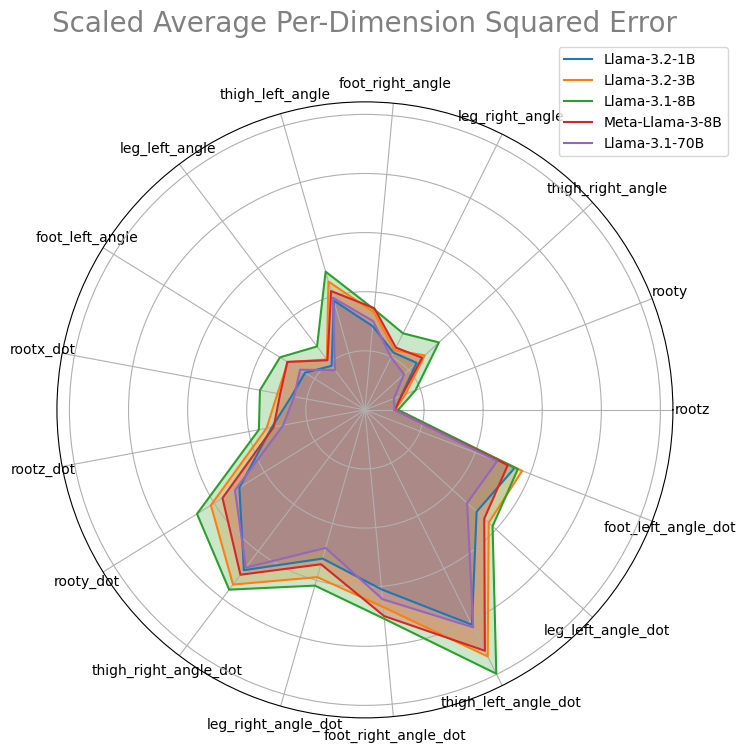

In [33]:
# Initialize a dictionary to store the errors for each LLM and each dimension
llm_errors = {
    llm: [[] for _ in range(n_observations)]
    for llm in loaded_dict[list(loaded_dict.keys())[0]].keys()
}

# Extract the scaled_average_perdim_squared_error for each LLM across all episodes
for episode in loaded_dict:
    for llm in loaded_dict[episode]:
        errors = loaded_dict[episode][llm]["scaled_average_perdim_squared_error"]
        # errors = loaded_dict[episode][llm]["perdim_ks"]
        for dim in range(n_observations):
            llm_errors[llm][dim].append(errors[dim])

# Compute the mean for each LLM and each dimension
llm_means = {}
for llm, errors in llm_errors.items():
    llm_means[llm] = [np.mean(dim_errors) for dim_errors in errors]


# Function to create a radar chart
def create_radar_chart(data, categories, title):
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for llm, values in data.items():
        values += values[:1]
        ax.fill(angles, values, alpha=0.25)
        ax.plot(angles, values, label=llm)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(title, size=20, color="gray", y=1.1)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))

    plt.show()


# Create the radar chart
create_radar_chart(llm_means, dim_names, "Scaled Average Per-Dimension Squared Error")